<a href="https://colab.research.google.com/github/Juancard/multi-label-classification-on-data-streamings/blob/master/20ng_clasificaciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install --upgrade pip
!pip install scikit-multilearn
!pip install liac-arff
!pip install requests
!pip install scikit-multiflow
!pip install seaborn

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.1.1)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
import os, sys
from skmultilearn.dataset import load_dataset, load_from_arff
import numpy as np
import pandas as pd
import seaborn as sns
#TESIS_DIR="/content/drive/My Drive/tesis_cardona_mll_streaming"
TESIS_DIR="../"

In [2]:
def load_20ng_dataset():
  arff_path = os.path.join(TESIS_DIR, "datasets/20ng/meka/20NG-F.arff")
  N_LABELS = 20
  label_location="start"
  arff_file_is_sparse = False
  X_mulan, y_mulan, feature_names, label_names = load_from_arff(
    arff_path, 
    N_LABELS,
    label_location=label_location,
    load_sparse=arff_file_is_sparse,
    return_attribute_definitions=True
  )
  return X_mulan, y_mulan, feature_names, label_names

In [ ]:
from sklearn.datasets import fetch_20newsgroups, fetch_20newsgroups_vectorized
newsgroups_all = fetch_20newsgroups(subset='all')
newsgroups_all.target

array([10,  3, 17, ...,  3,  1,  7])

In [ ]:
newsgroups_all.data[0]
len(list(map(lambda x: x.split("/")[-1], newsgroups_all.filenames)))#, (list(map(lambda x: x.split("/")[-1], newsgroups_all.filenames)))

18846

# Multi-label - Batch

## EDA

Usa dataset de Meka y se toma del siguiente enlace: https://sourceforge.net/projects/meka/files/Datasets/

In [ ]:
X_mulan, y_mulan, feature_names, label_names = load_20ng_dataset()

In [ ]:
print("Meka:")
print("Instancias: {}".format(X_mulan.shape[0]))
print("Features: {}".format(len(feature_names)))
print("Labels: {}".format(len(label_names)))
print("Labels por instancias (promedio): {}".format(round(y_mulan.sum(axis=1).mean(), 2)))
# print("Instancias de entrenamiento: {}".format(X_mulan_train.shape[0]))
# print("Instancias de testing: {}".format(X_mulan_test.shape[0]))

Meka:
Instancias: 19300
Features: 1006
Labels: 20
Labels por instancias (promedio): 1.03


In [ ]:
label_names, "---", feature_names[-10:]

([('comp.os_ms_windows_misc', ['0', '1']),
  ('religion.rmisc', ['0', '1']),
  ('rec.sport.baseball', ['0', '1']),
  ('sci.space', ['0', '1']),
  ('comp.sys.mac_hardware', ['0', '1']),
  ('sci.med', ['0', '1']),
  ('politics.pmisc', ['0', '1']),
  ('rec.autos', ['0', '1']),
  ('misc_forsale', ['0', '1']),
  ('politics.mideast', ['0', '1']),
  ('rec.motorcycles', ['0', '1']),
  ('politics.guns', ['0', '1']),
  ('rec.sport.hockey', ['0', '1']),
  ('comp.sys.ibm_pc_hardware', ['0', '1']),
  ('comp.graphics', ['0', '1']),
  ('sci.crypt', ['0', '1']),
  ('sci.electronics', ['0', '1']),
  ('religion.christian', ['0', '1']),
  ('religion.atheism', ['0', '1']),
  ('comp.windows_x', ['0', '1'])],
 '---',
 [('written', 'NUMERIC'),
  ('wrong', 'NUMERIC'),
  ('wrote', 'NUMERIC'),
  ('x11', 'NUMERIC'),
  ('xx', 'NUMERIC'),
  ('yeah', 'NUMERIC'),
  ('year', 'NUMERIC'),
  ('years', 'NUMERIC'),
  ('york', 'NUMERIC'),
  ('young', 'NUMERIC')])

## Problem Transformation - Binary Relevance


In [ ]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
import time

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_mulan, y_mulan, test_size=0.4)
x_train, x_test, y_train, y_test

(<11580x1006 sparse matrix of type '<class 'numpy.float64'>'
 	with 369957 stored elements in Compressed Sparse Row format>,
 <7720x1006 sparse matrix of type '<class 'numpy.float64'>'
 	with 249122 stored elements in Compressed Sparse Row format>,
 <11580x20 sparse matrix of type '<class 'numpy.longlong'>'
 	with 11927 stored elements in Compressed Sparse Row format>,
 <7720x20 sparse matrix of type '<class 'numpy.longlong'>'
 	with 7930 stored elements in Compressed Sparse Row format>)

In [ ]:
start=time.time()
classifier = BinaryRelevance(
    classifier = RandomForestClassifier(),
    require_dense = [False, True]
)

classifier.fit(x_train, y_train)

print('training time taken: ',round(time.time()-start,0),'seconds')

training time taken:  103.0 seconds


In [ ]:
start=time.time()
y_hat=classifier.predict(x_test)
print('prediction time taken: ',round(time.time()-start,0),'seconds')

prediction time taken:  4.0 seconds


In [ ]:
import sklearn.metrics as metrics
def ml_accuracy(y_test, y_hat):
  def accuracy(x): 
    return 1 - np.mean(y_test.T[x] != y_hat.T[x])  
  return [accuracy(i) for i in range(y_test.shape[1])]

br_acc=ml_accuracy(y_test, y_hat)
br_f1=metrics.f1_score(y_test, y_hat, average='micro')
br_hamm=metrics.hamming_loss(y_test,y_hat)
print('Binary Relevance Accuracy (all):',br_acc)
print('Binary Relevance Accuracy (mean):',round(np.mean(br_acc),3))
print('Binary Relevance F1-score:',round(br_f1,3))
print('Binary Relevance Hamming Loss:',round(br_hamm,3))

Binary Relevance Accuracy (all): [0.9716321243523317, 0.9625647668393783, 0.9691709844559586, 0.9775906735751295, 0.9606217616580313, 0.9595854922279794, 0.9549222797927462, 0.9672279792746115, 0.9746113989637306, 0.9857512953367875, 0.9768134715025907, 0.972279792746114, 0.9832901554404144, 0.9610103626943006, 0.9610103626943006, 0.9839378238341968, 0.9516839378238344, 0.9737046632124353, 0.9665803108808291, 0.9647668393782385]
Binary Relevance Accuracy (mean): 0.969
Binary Relevance F1-score: 0.582
Binary Relevance Hamming Loss: 0.031


## Problem Transformation - Classifier Chains

In [ ]:
from skmultilearn.problem_transform import ClassifierChain

In [ ]:
classifier = ClassifierChain(
    classifier = RandomForestClassifier(),
    require_dense = [False, True],
    order=[i for i in range(len(label_names))]
)
start=time.time()
classifier.fit(x_train,y_train)

print('training time taken: ',round(time.time()-start,0),'seconds')

training time taken:  101.0 seconds


In [ ]:
start=time.time()
y_hat=classifier.predict(x_test)
print('prediction time taken: ',round(time.time()-start,0),'seconds')

prediction time taken:  4.0 seconds


In [ ]:
br_acc=ml_accuracy(y_test, y_hat)
cc_f1=metrics.f1_score(y_test, y_hat, average='micro')
cc_hamm=metrics.hamming_loss(y_test,y_hat)
print('Classifier Chain Accuracy (all):',br_acc)
print('Classifier Chain Accuracy (mean):',round(np.mean(br_acc),3))
print('Classifier Chain F1-score:',round(cc_f1,3))
print('Classifier Chain Hamming Loss:',round(cc_hamm,3))

Classifier Chain Accuracy (all): [0.9712435233160622, 0.9629533678756478, 0.9691709844559586, 0.9768134715025907, 0.9591968911917099, 0.9593264248704665, 0.9556994818652851, 0.9686528497409327, 0.9757772020725389, 0.9865284974093264, 0.9787564766839378, 0.9735751295336788, 0.9848445595854922, 0.9611398963730571, 0.9633419689119171, 0.9832901554404144, 0.9525906735751297, 0.9737046632124353, 0.9668393782383421, 0.9615284974093266]
Classifier Chain Accuracy (mean): 0.969
Classifier Chain F1-score: 0.594
Classifier Chain Hamming Loss: 0.031


# Multi-label - Streaming

In [12]:
!pip install scikit-multiflow scikit-multilearn liac-arff
!pip install --upgrade scikit-multiflow

     |################################| 1.1 MB 552 kB/s eta 0:00:01
     |################################| 10.1 MB 1.2 MB/s eta 0:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 0.24.1
    Uninstalling pandas-0.24.1:
      Successfully uninstalled pandas-0.24.1
  Attempting uninstall: scikit-multiflow
    Found existing installation: scikit-multiflow 0.1.3
    Uninstalling scikit-multiflow-0.1.3:
      Successfully uninstalled scikit-multiflow-0.1.3


In [3]:
from skmultiflow.meta.multi_output_learner import MultiOutputLearner
from skmultiflow.meta import ClassifierChain
from skmultiflow.trees import LabelCombinationHoeffdingTreeClassifier
from skmultiflow.core.pipeline import Pipeline
from skmultiflow.data.data_stream import DataStream
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model.perceptron import Perceptron
from skmultilearn.dataset import load_dataset
from skmultiflow.evaluation.evaluate_prequential import EvaluatePrequential
from skmultiflow.data import ConceptDriftStream
from skmultiflow.data import MultilabelGenerator
import numpy as np

In [4]:
X_stream, y_stream, feature_names, label_names = load_20ng_dataset()
data_stream = DataStream(data=X_stream.todense(), y=y_stream.todense())
X_stream, y_stream

(<19300x1006 sparse matrix of type '<class 'numpy.float64'>'
 	with 619079 stored elements in LInked List format>,
 <19300x20 sparse matrix of type '<class 'numpy.int64'>'
 	with 19857 stored elements in LInked List format>)

## Ordena dataset
Se debe ordenar el dataset para que el modelo funcione. Esto es, asegurarse que durante la fase de pre-entrenamiento, el modelo reciba ejemplos de cada clase de las labels. 

In [ ]:
def unique_classes_per_label(a):
    b = np.sort(a,axis=0)
    return (b[1:] != b[:-1]).sum(axis=0)+1

unique_classes_per_label(y_stream.todense()[0:499])

matrix([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2]])

Se observa que los primeros 500 ejemplos no poseen en sí mismos todas las clases en cada una de sus labels.   

In [ ]:
idx_per_label = []
for label in range(0, data_stream.y.shape[1]):
    i = 0
    for row in data_stream.y:
        if row[label] == 1 and i not in idx_per_label:
            idx_per_label.append(i)
            break
        i += 1

test_ok = True
for i in range(0, data_stream.y.shape[1]):
    test_ok &= data_stream.y[idx_per_label[i]][i] == 1
print("idx_per_label se cargó correctamente") if test_ok else print("Falló el test")

idx_per_label se cargó correctamente


In [ ]:
y_stream_sorted = np.append(
    data_stream.y[idx_per_label], 
    data_stream.y[ 
        [i for i in range(0,len(data_stream.y)) if i not in idx_per_label] 
    ],
    axis=0
)
y_stream_sorted

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [ ]:
X_stream_sorted = np.append(
    data_stream.X[idx_per_label], 
    data_stream.X[ 
        [i for i in range(0,len(data_stream.X)) if i not in idx_per_label] 
    ],
    axis=0
)
data_stream.X, data_stream.X.shape

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]), (19300, 1006))

In [ ]:
unique_classes_per_label(y_stream_sorted[0:499])

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

Se observa que los primeros 500 ejemplos ahora sí poseen todas las clases.

## Binary Relevance

In [ ]:
%matplotlib notebook
data_stream = DataStream(data=X_stream_sorted, y=y_stream_sorted)
classifier_br = MultiOutputLearner(
    Perceptron()
)
pipe_br = Pipeline([('classifier', classifier_br)])
evaluator = EvaluatePrequential(
    show_plot=True, 
    pretrain_size=500, 
    max_samples=500000,
    metrics=["exact_match", "hamming_score", "hamming_loss", "running_time", "model_size"],
    output_file='results_br.csv'
)
evaluator.evaluate(stream=data_stream, model=pipe_br)

<IPython.core.display.Javascript object>

Prequential Evaluation
Evaluating 20 target(s).
Pre-training on 500 sample(s).
Evaluating...
 #################### [100%] [242.73s]
Processed samples: 19300
Mean performance:
M0 - Hamming score: 0.0332
M0 - Hamming loss : 0.9668
M0 - Exact matches: 0.5009
M0 - Training time (s)  : 200.96
M0 - Testing time  (s)  : 23.70
M0 - Total time    (s)  : 224.67
M0 - Size (kB)          : 653.0713


[Pipeline(steps=[('classifier',
                  MultiOutputLearner(base_estimator=Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
            fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
            penalty=None, random_state=0, shuffle=True, tol=0.001,
            validation_fraction=0.1, verbose=0, warm_start=False)))])]

<IPython.core.display.Javascript object>

## Classifier Chain

In [ ]:
%matplotlib notebook
data_stream = DataStream(data=X_stream_sorted, y=y_stream_sorted)
data_stream.prepare_for_use()
classifier_cc = ClassifierChain(
    Perceptron()
)
pipe_cc = Pipeline([('classifier', classifier_cc)])
evaluator = EvaluatePrequential(
    show_plot=True, 
    pretrain_size=500, 
    max_samples=500000,
    metrics=["exact_match", "hamming_score", "hamming_loss", "running_time", "model_size"],
    output_file='results_cc.csv'
)
evaluator.evaluate(stream=data_stream, model=pipe_cc)

/usr/local/lib/python3.6/dist-packages/skmultiflow/data/base_stream.py:194: FutureWarning: 'prepare_for_use' has been deprecated in v0.5.0 and will be removed in v0.7.0.
New instances of the Stream class are now ready to use after instantiation.
  category=FutureWarning)


<IPython.core.display.Javascript object>

Prequential Evaluation
Evaluating 20 target(s).
Pre-training on 500 sample(s).
Evaluating...
 #################### [100%] [246.20s]
Processed samples: 19300
Mean performance:
M0 - Hamming score: 0.0334
M0 - Hamming loss : 0.9666
M0 - Exact matches: 0.5474
M0 - Training time (s)  : 194.19
M0 - Testing time  (s)  : 31.62
M0 - Total time    (s)  : 225.81
M0 - Size (kB)          : 659.6592


[Pipeline(steps=[('classifier',
                  ClassifierChain(base_estimator=Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
            fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
            penalty=None, random_state=0, shuffle=True, tol=0.001,
            validation_fraction=0.1, verbose=0, warm_start=False),
                                  order=None, random_state=None))])]

## Label Combination Hoeffding Tree

In [ ]:
%matplotlib notebook
data_stream = DataStream(data=X_stream.todense(), y=y_stream.todense())
classifier_lcht = LabelCombinationHoeffdingTreeClassifier(
    n_labels=data_stream.n_targets
)
pipe_lcht = Pipeline([('classifier', classifier_lcht)])
evaluator = EvaluatePrequential(
    show_plot=True, 
    pretrain_size=1930, 
    max_samples=500000,
    metrics=["exact_match", "hamming_score", "hamming_loss", "running_time", "model_size"],
    output_file='results_lcht.csv'
)
evaluator.evaluate(stream=data_stream, model=pipe_lcht)

<IPython.core.display.Javascript object>

Prequential Evaluation
Evaluating 20 target(s).
Pre-training on 1930 sample(s).
Evaluating...
 ##------------------ [10%] [176.19s]

/usr/local/lib/python3.6/dist-packages/skmultiflow/bayes/utils.py:37: RuntimeWarning: overflow encountered in double_scalars
  X[att_idx], class_index)
/usr/local/lib/python3.6/dist-packages/skmultiflow/utils/utils.py:62: RuntimeWarning: invalid value encountered in double_scalars
  dictionary[key] = value / factor


 ###----------------- [15%] [640.06s]Can not normalize, normalization factor is NaN
Processed samples: 2971
Mean performance:
M0 - Hamming score: 0.0117
M0 - Hamming loss : 0.9883
M0 - Exact matches: 0.2299
M0 - Training time (s)  : 278.54
M0 - Testing time  (s)  : 309.38
M0 - Total time    (s)  : 587.92
M0 - Size (kB)          : 15546.1094


/usr/local/lib/python3.6/dist-packages/skmultiflow/bayes/utils.py:37: RuntimeWarning: invalid value encountered in double_scalars
  X[att_idx], class_index)


[Pipeline(steps=[('classifier',
                  LabelCombinationHoeffdingTreeClassifier(binary_split=False,
                                                          grace_period=200,
                                                          leaf_prediction='nba',
                                                          max_byte_size=33554432,
                                                          memory_estimate_period=1000000,
                                                          n_labels=20,
                                                          nb_threshold=0,
                                                          no_preprune=False,
                                                          nominal_attributes=None,
                                                          remove_poor_atts=False,
                                                          split_confidence=1e-07,
                                                          split_criterion='info_gain',
     

<IPython.core.display.Javascript object>

# Stream Sintético

In [5]:
from skmultiflow.meta.multi_output_learner import MultiOutputLearner
from skmultiflow.meta import ClassifierChain
from skmultiflow.trees import LabelCombinationHoeffdingTreeClassifier
from skmultiflow.core.pipeline import Pipeline
from skmultiflow.data.data_stream import DataStream
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model.perceptron import Perceptron
from skmultilearn.dataset import load_dataset
from skmultiflow.evaluation.evaluate_prequential import EvaluatePrequential
from skmultiflow.data import ConceptDriftStream
from skmultiflow.data import MultilabelGenerator
from matplotlib import pyplot as plt
import numpy as np

In [6]:
from sklearn.datasets import make_multilabel_classification
from skmultiflow.utils import check_random_state
class MultilabelGenerator2( MultilabelGenerator ):
    # IGUAL QUE LA FUNCION ORIGINAL PERO NO PERMITE INSTANCIAS SIN ETIQUETAS
    def _prepare_for_use(self):
        print("Preparando Generador Multietiquetas v2")
        self._random_state = check_random_state(self.random_state)
        self.X, self.y = make_multilabel_classification(n_samples=self.n_samples,
                                                        n_features=self.n_features,
                                                        n_classes=self.n_targets,
                                                        n_labels=self.n_labels,
                                                        allow_unlabeled=False, ## SE AGREGA ESTA LINEA 
                                                        random_state=self._random_state)
        self.target_names = ["target_" + str(i) for i in range(self.n_targets)]
        self.feature_names = ["att_num_" + str(i) for i in range(self.n_num_features)]
        self.target_values = np.unique(self.y).tolist() if self.n_targets == 1 else \
            [np.unique(self.y[:, i]).tolist() for i in range(self.n_targets)]
    # por alguna razón la clase MultilabelGenerator no implementa el método has_more_classes
    def has_more_samples( self ):
        return self.n_remaining_samples() > 0
class ConceptDriftStream2(ConceptDriftStream):
    def prob_drift( self, batch_size=1):
        x = -4.0 * float(self.sample_idx - self.position) / float(self.width)
        probability_drift = 1.0 / (1.0 + np.exp(x))
        x, y = super().next_sample(batch_size)
        return probability_drift
    def next_sample(self, batch_size=1):
      """
        Copio y pego textual de next_sample. 
        Solo quito el planchado realizado sobre la matriz de etiquetas.
        "self.current_sample_y.flatten()" pasa a ser "self.current_sample_y"
      """
      self.current_sample_x = np.zeros((batch_size, self.n_features))
      self.current_sample_y = np.zeros((batch_size, self.n_targets))
      for j in range(batch_size):
          self.sample_idx += 1
          x = -4.0 * float(self.sample_idx - self.position) / float(self.width)
          probability_drift = 1.0 / (1.0 + np.exp(x))
          if self._random_state.rand() > probability_drift:
              X, y = self.stream.next_sample()
          else:
              X, y = self.drift_stream.next_sample()
          self.current_sample_x[j, :] = X
          self.current_sample_y[j, :] = y
      return self.current_sample_x, self.current_sample_y

def evaluar(stream, model, pretrain_size=0.1):
  stream.restart()
  evaluator = EvaluatePrequential(
      show_plot=True, 
      pretrain_size=round(stream.n_remaining_samples() * pretrain_size), 
      max_samples=1000000,
      metrics=["exact_match", "hamming_score", "hamming_loss", "running_time", "model_size"],
      output_file='results_br_stream_no_drift.csv'
  )
  evaluator.evaluate(stream=stream, model=model)

def label_skew_graph(y_array, color="red", print_top=10):
  df = pd.DataFrame(y_array, columns=[i for i in range(0,y_array.shape[1])])
  labels_set_count = df.groupby(df.columns.tolist(),as_index=False).size().sort_values(ascending=False)
  print("Top ",print_top,": \n", labels_set_count[:print_top])
  labels_set_count_scaled = (labels_set_count-labels_set_count.min())/(labels_set_count.max()-labels_set_count.min())
  sns.lineplot(data=labels_set_count_scaled.values, color=color)


In [15]:
X_stream, y_stream, feature_names, label_names = load_20ng_dataset()
data_stream = DataStream(data=X_stream.todense(), y=y_stream.todense(), name="ng20")
X_stream, y_stream

(<19300x1006 sparse matrix of type '<class 'numpy.float64'>'
 	with 619079 stored elements in LInked List format>,
 <19300x20 sparse matrix of type '<class 'numpy.int64'>'
 	with 19857 stored elements in LInked List format>)

## Stream original

In [16]:
X_stream, y_stream, feature_names, label_names = load_20ng_dataset()
data_stream = DataStream(data=X_stream.todense(), y=y_stream.todense(), name="newsgroup20")
print(data_stream.n_remaining_samples())
print(data_stream.target_names)

19300
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [ ]:
%matplotlib notebook
classifier_br = MultiOutputLearner(
    Perceptron()
)
evaluar(data_stream, classifier_br, 0.1)
data_stream.restart()

<IPython.core.display.Javascript object>

Prequential Evaluation
Evaluating 20 target(s).
Pre-training on 1930 sample(s).
Evaluating...
 #################### [100%] [245.14s]
Processed samples: 19300
Mean performance:
M0 - Hamming score: 0.0339
M0 - Hamming loss : 0.9661
M0 - Exact matches: 0.5136
M0 - Training time (s)  : 201.14
M0 - Testing time  (s)  : 24.59
M0 - Total time    (s)  : 225.73
M0 - Size (kB)          : 652.6680


## Stream multi label sintético

In [17]:
labels_por_instancia = y_stream.sum(axis=1).mean()
print("Cardinalidad:", labels_por_instancia)
ml_stream = MultilabelGenerator2(
  n_features=data_stream.n_features, 
  n_targets=data_stream.n_targets, 
  n_labels=1,#labels_por_instancia,
  n_samples=data_stream.n_remaining_samples() * 2
)
print("Cantidad de instancias:", ml_stream.n_remaining_samples())
print("Targets: ", ml_stream.target_names)

Cardinalidad: 1.028860103626943
Preparando Generador Multietiquetas v2
Cantidad de instancias: 38600
Targets:  ['target_0', 'target_1', 'target_2', 'target_3', 'target_4', 'target_5', 'target_6', 'target_7', 'target_8', 'target_9', 'target_10', 'target_11', 'target_12', 'target_13', 'target_14', 'target_15', 'target_16', 'target_17', 'target_18', 'target_19']


In [ ]:
classifier_br = MultiOutputLearner(
    Perceptron()
)
evaluar(ml_stream, classifier_br)
data_stream.restart()

<IPython.core.display.Javascript object>

Prequential Evaluation
Evaluating 101 target(s).
Pre-training on 8781 sample(s).
Evaluating...
 #################### [100%] [4832.25s]
Processed samples: 87814
Mean performance:
M0 - Hamming score: 0.0045
M0 - Hamming loss : 0.9955
M0 - Exact matches: 0.0007
M0 - Training time (s)  : 4238.23
M0 - Testing time  (s)  : 459.02
M0 - Total time    (s)  : 4697.26
M0 - Size (kB)          : 486.1992


In [23]:
X, y = ml_stream.next_sample(1)
y

array([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])

In [24]:
labels_sample = list(y.flat)
labels_name_of_sample = [label_names[idx][0] for idx, _ in filter(lambda x: x[1]==1, enumerate(labels_sample)) ]
print("Instancia tiene etiquetas: {}".format(labels_name_of_sample))

Instancia tiene etiquetas: ['class4', 'class15']


In [25]:
features_mask = [X > 0][0][0]
features_sample = np.array([i[0] for i in feature_names])[features_mask]
features_sample

array(['numeric3', 'numeric18', 'numeric53', 'numeric70', 'numeric73',
       'numeric77', 'numeric85', 'numeric109', 'numeric124', 'numeric132',
       'numeric199', 'numeric212', 'numeric213', 'numeric236',
       'numeric240', 'numeric252', 'numeric263', 'numeric309',
       'numeric318', 'numeric339', 'numeric347', 'numeric403',
       'numeric446', 'numeric498', 'numeric504', 'numeric518',
       'numeric531', 'numeric563', 'numeric573', 'numeric576',
       'numeric579', 'numeric586', 'numeric604', 'numeric654',
       'numeric664', 'numeric670', 'numeric707', 'numeric708',
       'numeric734', 'numeric782', 'numeric793', 'numeric807',
       'numeric809', 'numeric814', 'numeric828', 'numeric937',
       'numeric946', 'numeric948'], dtype='<U11')

## Stream con cambio de concepto 
Stream original + Stream ml 

In [18]:
drift_stream = ConceptDriftStream2(
    stream=data_stream, 
    drift_stream=ml_stream, 
    position=round(data_stream.n_remaining_samples() * 0.95),
    #width=1000
)
drift_stream.restart()
n=0

prob_drift_array = []
while drift_stream.has_more_samples():
  prob_drift_array.append(drift_stream.prob_drift())
  n+=1
print("Cantidad de ejemplos: ", n, " (cambia con cada corrida)")
print("drift_stream.target_names: ", drift_stream.target_names)
drift_stream.restart()

Cantidad de ejemplos:  56935  (cambia con cada corrida)
drift_stream.target_names:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


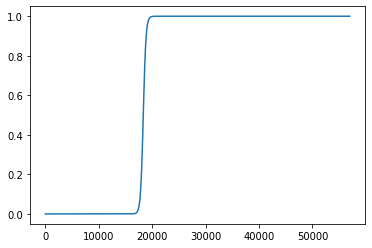

In [ ]:
%matplotlib inline
plt.plot(prob_drift_array)

In [ ]:
%matplotlib notebook
classifier_br = MultiOutputLearner(
    Perceptron()
)
evaluar(drift_stream, classifier_br, 0.2)
data_stream.restart()

<IPython.core.display.Javascript object>

Prequential Evaluation
Evaluating 101 target(s).
Pre-training on 26344 sample(s).
Evaluating...
 ###################- [95%] [6165.34s]Processed samples: 129519
Mean performance:
M0 - Hamming score: 0.0084
M0 - Hamming loss : 0.9916
M0 - Exact matches: 0.0215
M0 - Training time (s)  : 5687.62
M0 - Testing time  (s)  : 603.04
M0 - Total time    (s)  : 6290.66
M0 - Size (kB)          : 486.1992


## Label skew

Se siguen los pasos de: [Generating Synthetic Multi-label Data Streams (Read, J. et al)](https://users.ics.aalto.fi/jesse/papers/synth.pdf)

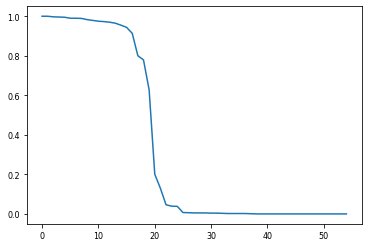

In [30]:
label_skew_graph(y_stream.toarray())

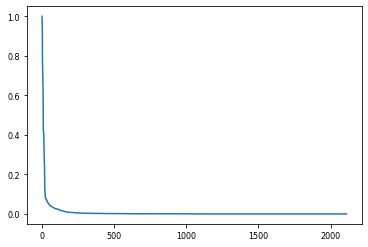

In [31]:
ml_stream.restart()
_, y_stream_ml = ml_stream.next_sample(ml_stream.n_remaining_samples())
label_skew_graph(y_stream_ml)
ml_stream.restart()

In [76]:
np.unique(y_stream_ml, axis=0).shape

(2004, 20)

In [77]:
np.sum(y_stream_ml, axis=1)

array([1, 3, 1, ..., 1, 2, 1])

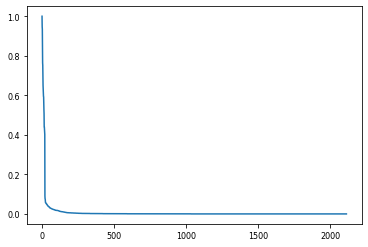

In [32]:
drift_stream.restart()
y_stream_drift = []
while drift_stream.has_more_samples():
  _, y_stream_drift_sample = drift_stream.next_sample()
  y_stream_drift.append(y_stream_drift_sample.flatten())
y_stream_drift = np.array(y_stream_drift)
label_skew_graph(y_stream_drift)
drift_stream.restart()

##Label Distribution

### Original 

Número de etiquetas por instancia vs frecuencia
 1     18765
2       528
3         4
4         1
6         1
14        1
dtype: int64
Número de etiquetas por instancia vs frecuencia (escalada)
 1     1.000000
2     0.028086
3     0.000160
4     0.000000
6     0.000000
14    0.000000
dtype: float64


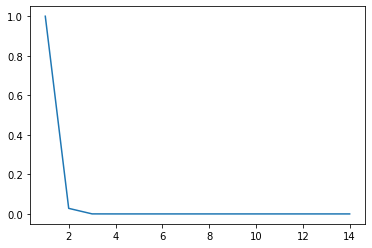

In [12]:
df = pd.DataFrame(y_stream.toarray(), columns=[i for i in range(0,y_stream.shape[1])])
labels_distribution = df.sum(axis=1).value_counts().sort_index()
print("Número de etiquetas por instancia vs frecuencia\n", labels_distribution)
labels_distribution_scaled = (labels_distribution-labels_distribution.min())/(labels_distribution.max()-labels_distribution.min())
print("Número de etiquetas por instancia vs frecuencia (escalada)\n", labels_distribution_scaled)
sns.lineplot(data=labels_distribution_scaled)

Poisson - Número de etiquetas por instancia vs frecuencia
 0    17429
1     1775
2       95
3        1
dtype: int64
Poisson - Número de etiquetas por instancia vs frecuencia (escalada)
 0    1.000000
1    0.101790
2    0.005394
3    0.000000
dtype: float64


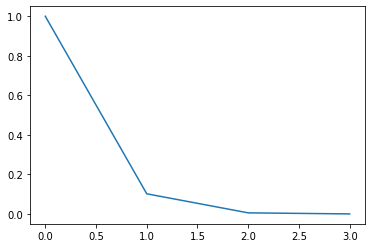

In [13]:
poisson_labels_distribution = pd.Series(np.random.poisson(lam=0.1, size=y_stream.shape[0])).value_counts().sort_index()
print("Poisson - Número de etiquetas por instancia vs frecuencia\n", poisson_labels_distribution)
poisson_labels_distribution_scaled = (poisson_labels_distribution-poisson_labels_distribution.min())/(poisson_labels_distribution.max()-poisson_labels_distribution.min())
print("Poisson - Número de etiquetas por instancia vs frecuencia (escalada)\n", poisson_labels_distribution_scaled)
sns.lineplot(data=poisson_labels_distribution_scaled)

###Sintético


Número de etiquetas por instancia vs frecuencia
 1    22336
2    11308
3     3805
4      930
5      181
6       30
7       10
dtype: int64
Número de etiquetas por instancia vs frecuencia (escalada)
 1    1.000000
2    0.506047
3    0.169981
4    0.041208
5    0.007659
6    0.000896
7    0.000000
dtype: float64


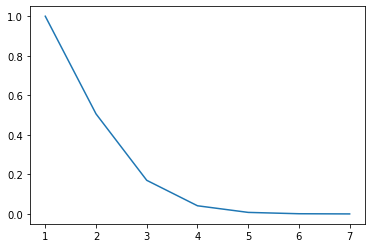

In [14]:
ml_stream.restart()
_, y_stream_ml = ml_stream.next_sample(ml_stream.n_remaining_samples())
df = pd.DataFrame(y_stream_ml, columns=[i for i in range(0,y_stream_ml.shape[1])])
labels_distribution = df.sum(axis=1).value_counts().sort_index()
print("Número de etiquetas por instancia vs frecuencia\n", labels_distribution)
labels_distribution_scaled = (labels_distribution-labels_distribution.min())/(labels_distribution.max()-labels_distribution.min())
print("Número de etiquetas por instancia vs frecuencia (escalada)\n", labels_distribution_scaled)
sns.lineplot(data=labels_distribution_scaled)
ml_stream.restart()

Poisson - Número de etiquetas por instancia vs frecuencia
 0    11780
1     5761
2     1469
3      250
4       35
5        3
6        2
dtype: int64
Poisson - Número de etiquetas por instancia vs frecuencia (escalada)
 0    1.000000
1    0.488962
2    0.124554
3    0.021056
4    0.002802
5    0.000085
6    0.000000
dtype: float64


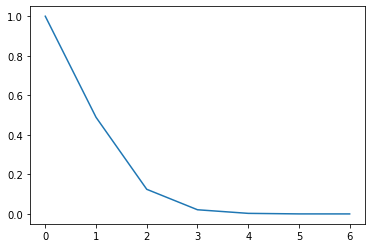

In [15]:
poisson_labels_distribution = pd.Series(np.random.poisson(lam=0.5, size=y_stream.shape[0])).value_counts().sort_index()
print("Poisson - Número de etiquetas por instancia vs frecuencia\n", poisson_labels_distribution)
poisson_labels_distribution_scaled = (poisson_labels_distribution-poisson_labels_distribution.min())/(poisson_labels_distribution.max()-poisson_labels_distribution.min())
print("Poisson - Número de etiquetas por instancia vs frecuencia (escalada)\n", poisson_labels_distribution_scaled)
sns.lineplot(data=poisson_labels_distribution_scaled)

## Labels relationship

In [42]:
#AÚN NO SE PENSÓÓ UNA IMPLEMENTACIÓN ADECUADA PARA GENERAR ESTE GRÁFICO 
#
#df = pd.DataFrame(y_stream.toarray(), columns=[i for i in range(0,y_stream.shape[1])])
#np.where(df!=0)[0], len(np.where(df!=0)[0]), len(np.unique(np.where(df!=0)[0]))

(array([    0,     1,     2, ..., 19297, 19298, 19299]), 19857, 19300)

## Stream sintético - Moa

In [8]:
def load_20ng_syn_stream(filepath):
  with open(filepath) as arff_file:
    arff_file_content = [line.rstrip(",\n") + "\n" for line in arff_file]
    with open("/tmp/stream", "w") as f:
      f.write("".join(arff_file_content))
  arff_path = "/tmp/stream"
  N_LABELS = 20
  label_location="start"
  arff_file_is_sparse = False
  X_mulan, y_mulan, feature_names, label_names = load_from_arff(
    arff_path, 
    N_LABELS,
    label_location=label_location,
    load_sparse=arff_file_is_sparse,
    return_attribute_definitions=True
  )
  return X_mulan, y_mulan, feature_names, label_names

In [53]:
filepath = os.path.join(TESIS_DIR, "streams/20ng_syn_19300_skew1.arff")
X_moa_syn_stream_skew1, y_moa_syn_stream_skew1, feature_names, label_names = load_20ng_syn_stream(filepath)
print(X_moa_syn_stream.shape, y_moa_syn_stream.shape)

(19300, 1006) (19300, 20)


In [9]:
filepath = os.path.join(TESIS_DIR, "streams/20ng_syn_19300_skew0.arff")
X_moa_syn_stream_skew0, y_moa_syn_stream_skew0, feature_names, label_names = load_20ng_syn_stream(filepath)
print(X_moa_syn_stream_skew0.shape, y_moa_syn_stream_skew0.shape)

(19300, 1006) (19300, 20)


In [23]:
filepath = os.path.join(TESIS_DIR, "streams/20ng_syn_19300_skew0_ld0.arff")
X_moa_syn_stream_skew0_ld0, y_moa_syn_stream_skew0_ld0, feature_names, label_names = load_20ng_syn_stream(filepath)
print(X_moa_syn_stream_skew0_ld0.shape, y_moa_syn_stream_skew0_ld0.shape)

(19300, 1006) (19300, 20)


In [12]:
filepath = os.path.join(TESIS_DIR, "streams/20ng_syn_19300_skew0_ld25_card0_5.arff")
X_moa_syn_stream_skew0_ld0_25_card0_5, y_moa_syn_stream_skew0_ld0_25_card0_5, feature_names, label_names = load_20ng_syn_stream(filepath)
print(X_moa_syn_stream_skew0_ld0_25_card0_5.shape, y_moa_syn_stream_skew0_ld0_25_card0_5.shape)

(19300, 1006) (19300, 20)


Prequential Evaluation
Evaluating 20 target(s).
Pre-training on 3860 sample(s).
Evaluating...
 ####---------------- [20%] [4.04s]

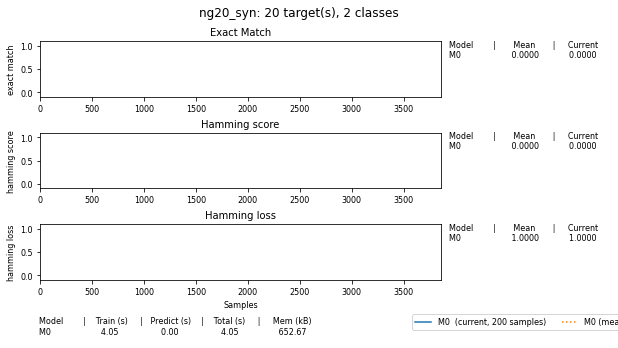

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

 #####--------------- [25%] [17.92s]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

 ######-------------- [30%] [30.63s]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

 #######------------- [35%] [43.48s]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

 ########------------ [40%] [56.25s]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

 #########----------- [45%] [69.10s]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

 ##########---------- [50%] [81.89s]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

 ###########--------- [55%] [94.73s]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

 ############-------- [60%] [107.41s]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

 #############------- [65%] [120.30s]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

 ##############------ [70%] [133.13s]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

 ###############----- [75%] [145.98s]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

 ################---- [80%] [158.92s]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

 #################--- [85%] [171.75s]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

 ##################-- [90%] [184.52s]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

 ###################- [95%] [197.25s]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

 #################### [100%] [210.22s]


<Figure size 432x288 with 0 Axes>

Processed samples: 19300
Mean performance:
M0 - Hamming score: 0.0177
M0 - Hamming loss : 0.9823
M0 - Exact matches: 0.0054
M0 - Training time (s)  : 178.96
M0 - Testing time  (s)  : 21.97
M0 - Total time    (s)  : 200.93
M0 - Size (kB)          : 652.6680


In [28]:
classifier_br = MultiOutputLearner(
    Perceptron()
)
evaluar(
    DataStream(data=X_moa_syn_stream_skew1.todense(), y=y_moa_syn_stream_skew1.todense(), name="ng20_syn"), 
    classifier_br,
    0.2
)

In [ ]:
label_skew_graph(X_moa_syn_stream_skew0_ld0.toarray(), color="blue")

Top  10 : 
 0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19
0  0  0  0  0  0  0  1  0  1  0   0   0   0   0   0   0   0   0   0     1716
1  0  0  0  0  0  1  0  0  0  0   0   0   0   0   1   0   0   0   0     1258
0  0  0  1  0  0  0  0  1  0  0   0   0   0   0   0   0   0   0   0     1201
         0  0  0  1  0  0  0  1   0   0   0   0   0   1   0   0   0      722
            1  0  1  0  0  0  0   0   0   0   0   0   0   0   0   0      655
1  0  0  1  0  0  0  0  0  0  0   0   0   0   0   0   0   0   1   0      645
0  0  0  0  0  0  0  0  0  0  0   0   0   1   0   0   1   0   0   0      583
   1  0  0  0  0  0  0  0  1  0   0   0   0   0   0   0   0   0   0      569
                           0  0   0   1   0   0   0   0   0   0   0      522
   0  0  1  1  0  0  0  0  0  0   0   0   0   0   0   0   0   0   0      504
dtype: int64


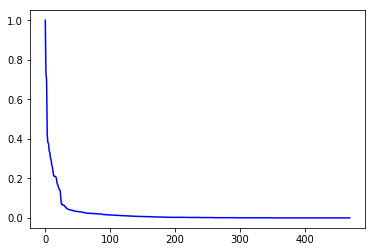

In [21]:
label_skew_graph(y_moa_syn_stream_skew0.toarray(), color="blue")

Top 20: 
 0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19
0  0  0  0  0  0  0  1  0  1  0   0   0   0   0   0   0   0   0   0     1716
1  0  0  0  0  0  1  0  0  0  0   0   0   0   0   1   0   0   0   0     1258
0  0  0  1  0  0  0  0  1  0  0   0   0   0   0   0   0   0   0   0     1201
         0  0  0  1  0  0  0  1   0   0   0   0   0   1   0   0   0      722
            1  0  1  0  0  0  0   0   0   0   0   0   0   0   0   0      655
1  0  0  1  0  0  0  0  0  0  0   0   0   0   0   0   0   0   1   0      645
0  0  0  0  0  0  0  0  0  0  0   0   0   1   0   0   1   0   0   0      583
   1  0  0  0  0  0  0  0  1  0   0   0   0   0   0   0   0   0   0      569
                           0  0   0   1   0   0   0   0   0   0   0      522
   0  0  1  1  0  0  0  0  0  0   0   0   0   0   0   0   0   0   0      504
dtype: int64
Top 20: 
 0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19
0  0  0  0  0  0  0  1  0  1  0   0   0   0   0   0   0   0

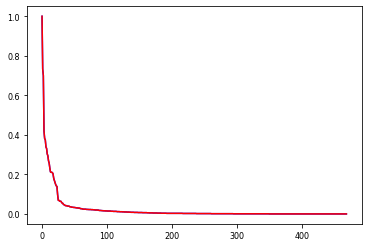

In [60]:
label_skew_graph(y_moa_syn_stream_skew1.toarray(), color="blue")
label_skew_graph(y_moa_syn_stream_skew0.toarray(), color="red")

Top  30 : 
 0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19
0  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   1   0   0     997
                                      1   0   0   0   0   0   0   0     997
                                      0   0   0   1   0   0   0   0     994
                              1   0   0   0   0   0   0   0   0   0     993
      1  0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   0     992
      0  1  0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   0     987
         0  0  0  0  1  0  0  0   0   0   0   0   0   0   0   0   0     987
               1  0  0  0  0  0   0   0   0   0   0   0   0   0   0     986
               0  0  0  0  0  0   0   0   0   0   0   1   0   0   0     980
                                          1   0   0   0   0   0   0     976
1  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   0     972
0  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   1     970
       

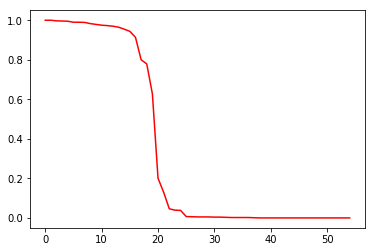

In [22]:
label_skew_graph(y_stream.toarray(), color="red", print_top=30)